# Week 4 Assessment: Principal Component Analysis (PCA)

## Learning Objective

In this notebook, we will implement PCA. We will implement the two versions of PCA as described in the lectures, which handles the when the dataset size exceeds the dataset dimensionality, as well as the case when we have the dimensionality greater than the size of the dataset.

We will break down the task of implementing PCA into small components and combine them in the end to produce the final algorithm. We will apply PCA to the MNIST dataset and observe how the reconstruction changes as we change the number of principal components used.


In [65]:
# PACKAGE: DO NOT EDIT
import numpy as np
import timeit

In [66]:
# PACKAGE: DO NOT EDIT
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/opt/conda/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Now, let's plot a digit from the dataset:

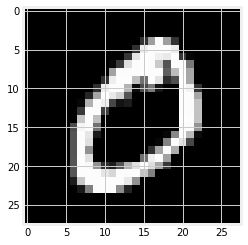

In [67]:
from ipywidgets import interact

from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original', data_home='./MNIST')
%matplotlib inline

plt.figure(figsize=(4,4))
plt.imshow(MNIST.data[0].reshape(28,28), cmap='gray');

Before we implement PCA, we will need to do some data preprocessing. In this assessment, some of them 
will be implemented by you, others we will take care of. However, when you are working on real world problems, you will need to do all these steps by yourself!

The preprocessing steps we will do are
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0-1.
2. Subtract from each image the mean $\mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the standard deviation of this dimension across the whole dataset.

The steps above ensure that our images will have zero mean and one variance. These preprocessing
steps are also known as [Data Normalization or Feature Scaling](https://en.wikipedia.org/wiki/Feature_scaling).

## 1. PCA

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $M$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Data normalization (`normalize`).
2. Find eigenvalues and corresponding eigenvectors for the covariance matrix $\boldsymbol S$.
   Sort by the largest eigenvalues and the corresponding eigenvectors (`eig`).

After these steps, we can then compute the projection and reconstruction of the data onto the spaced spanned by the top $M$ eigenvectors.

In [102]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

# ===YOU SHOULD EDIT THIS FUNCTION===
def normalize(X):
    """Normalize the given dataset X
    Args:
        X: ndarray, dataset
    
    Returns:
        (Xbar, mean, std): ndarray, Xbar is the normalized dataset
        with mean 0 and standard deviation 1; mean and std are the 
        mean and standard deviation respectively.
    
    Note:
        You will encounter dimensions where the standard deviation is
        zero, for those when you do normalization the normalized data
        will be NaN. Handle this by setting using `std = 1` for those 
        dimensions when doing normalization.
    """
    mu = np.mean(X, axis=0) # EDIT THIS
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = (X - mu) / std                  # EDIT THIS
    return Xbar, mu, std


In [103]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

# ===YOU SHOULD EDIT THIS FUNCTION===
def eig(S):
    """Compute the eigenvalues and corresponding eigenvectors 
        for the covariance matrix S.
    Args:
        S: ndarray, covariance matrix
    
    Returns:
        (eigvals, eigvecs): ndarray, the eigenvalues and eigenvectors

    Note:
        the eigenvals and eigenvecs SHOULD BE sorted in descending
        order of the eigen values
        
        Hint: take a look at np.argsort for how to sort in numpy.
    """
    eig_vals, eig_vecs = np.linalg.eig(S)
    sort = np.argsort(eig_vals)[::-1]
    
    return (eig_vals[sort], eig_vecs[:, sort]) # EDIT THIS

In [104]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

# ===YOU SHOULD EDIT THIS FUNCTION===
def projection_matrix(B):
    """Compute the projection matrix onto the space spanned by `B`
    Args:
        B: ndarray of dimension (D, M), the basis for the subspace
    
    Returns:
        P: the projection matrix
    """
    P = B @ np.linalg.inv(B.T @ B) @ B.T # EDIT THIS
    return P

Now, with the help of the functions you have implemented above, let's implement PCA! __When you implement `PCA`, do take advantage of the functions that you have implemented above.__

In [105]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

# ===YOU SHOULD EDIT THIS FUNCTION===
def PCA(X, num_components):
    """
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of datapoints
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: ndarray of the reconstruction
        of X from the first `num_components` principal components.
    """
    # Compute the data covariance matrix S
    S = np.cov(X, rowvar=False, bias=True)

    # Next find eigenvalues and corresponding eigenvectors for S by implementing eig().
    eig_vals, eig_vecs = eig(S)
    
    # Reconstruct the images from the lowerdimensional representation
    # To do this, we first need to find the projection_matrix (which you implemented earlier)
    # which projects our input data onto the vector space spanned by the eigenvectors
    P = projection_matrix(eig_vecs[:, :num_components]) # projection matrix
    
    # Then for each data point x_i in the dataset X 
    #   we can project the original x_i onto the eigenbasis.
    X_reconstruct = (P@X.T).T
    return X_reconstruct
    

In [106]:
## Some preprocessing of the data
NUM_DATAPOINTS = 1000
X = (MNIST.data.reshape(-1, 28 * 28)[:NUM_DATAPOINTS]) / 255.
Xbar, mu, std = normalize(X)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in true_divide


The greater number of of principal components we use, the smaller will our reconstruction
error be. Now, let's answer the following question: 


> How many principal components do we need
> in order to reach a Mean Squared Error (MSE) of less than $100$ for our dataset?



In [107]:
def mse(predict, actual):
    return np.square(predict - actual).sum(axis=1).mean()

In [108]:
loss = []
reconstructions = []
for num_component in range(1, 100):
    reconst = PCA(Xbar, num_component)
    error = mse(reconst, Xbar)
    reconstructions.append(reconst)
    # print('n = {:d}, reconstruction_error = {:f}'.format(num_component, error))
    loss.append((num_component, error))

reconstructions = np.asarray(reconstructions)
reconstructions = reconstructions * std + mu # "unnormalize" the reconstructed image
loss = np.asarray(loss)

LinAlgError: Array must not contain infs or NaNs

In [109]:
loss

[]

We can also put these numbers into perspective by plotting them.

TypeError: list indices must be integers or slices, not tuple

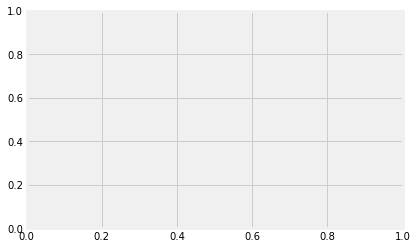

In [110]:
fig, ax = plt.subplots()
ax.plot(loss[:,0], loss[:,1]);
ax.axhline(100, linestyle='--', color='r', linewidth=2)
ax.xaxis.set_ticks(np.arange(1, 100, 5));
ax.set(xlabel='num_components', ylabel='MSE', title='MSE vs number of principal components');

But _numbers don't tell us everything_! Just what does it mean _qualitatively_ for the loss to decrease from around
$450.0$ to less than $100.0$?

Let's find out! In the next cell, we draw the original eight as the leftmost image. Then we show the reconstruction of the image on the right, in descending number of principal components used.

TypeError: list indices must be integers or slices, not tuple

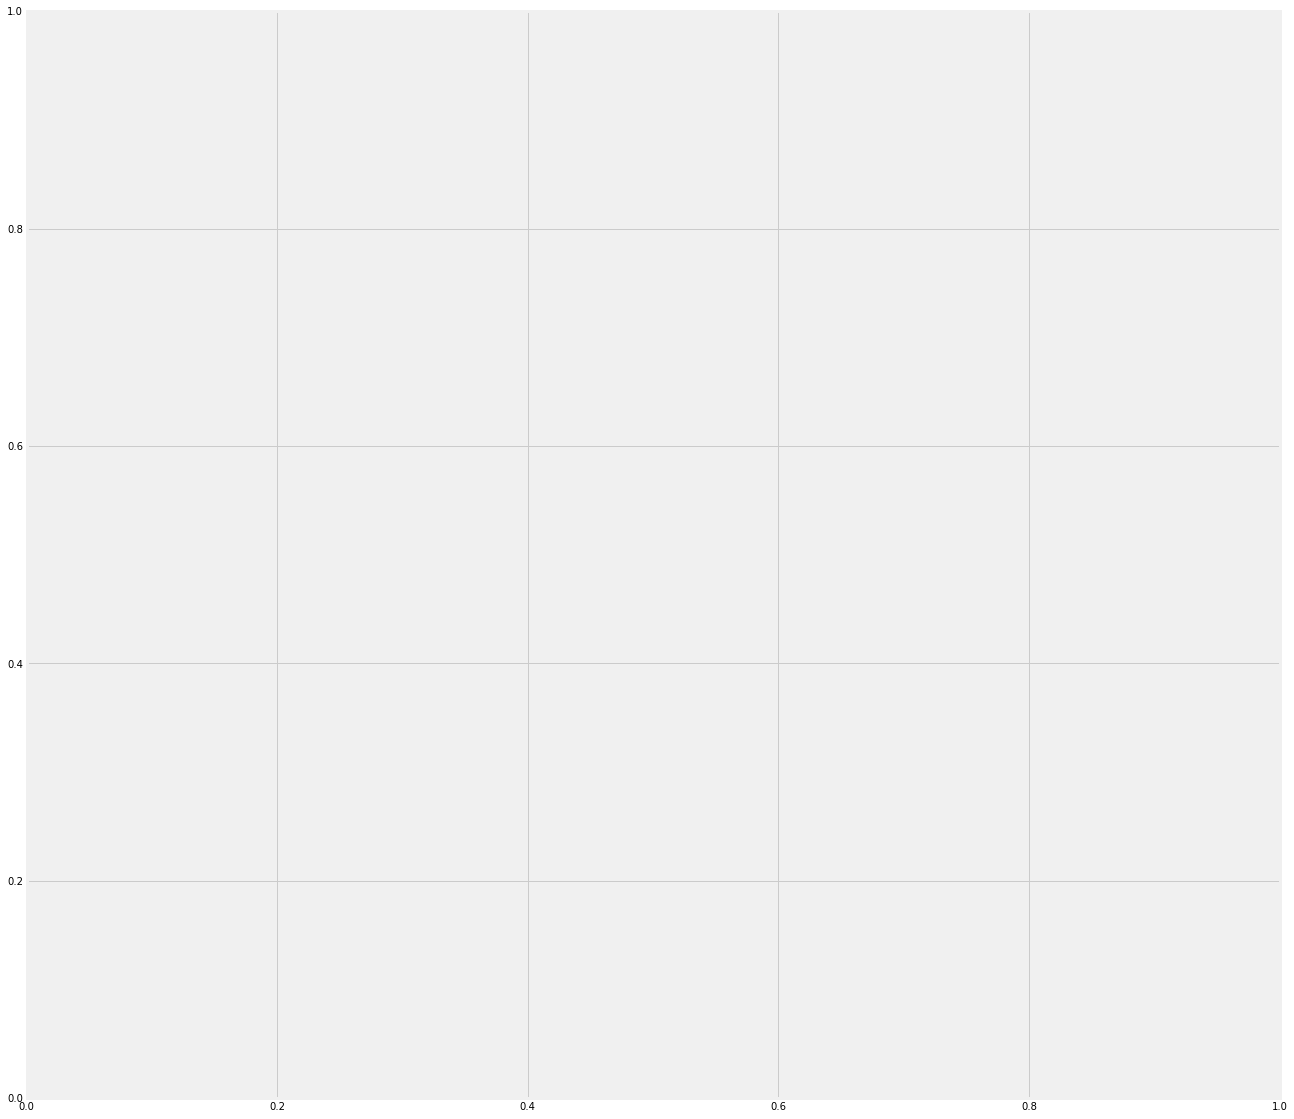

In [111]:
@interact(image_idx=(0, 1000))
def show_num_components_reconst(image_idx):
    fig, ax = plt.subplots(figsize=(20., 20.))
    actual = X[image_idx]
    x = np.concatenate([actual[np.newaxis, :], reconstructions[:, image_idx]])
    ax.imshow(np.hstack(x.reshape(-1, 28, 28)[np.arange(10)]),
              cmap='gray');
    ax.axvline(28, color='orange', linewidth=2)

We can also browse throught the reconstructions for other digits. Once again, `interact` becomes handy.

In [112]:
@interact(i=(0, 10))
def show_pca_digits(i=1):
    plt.figure(figsize=(4,4))
    actual_sample = X[i].reshape(28,28)
    reconst_sample = (reconst[i, :] * std + mu).reshape(28, 28)
    plt.imshow(np.hstack([actual_sample, reconst_sample]), cmap='gray')
    plt.show()

NameError: name 'reconst' is not defined

## 2. PCA for high-dimensional datasets

Sometimes, the dimensionality of our dataset may be larger than the number of data points we
have. Then it might be inefficient to perform PCA with the implementation above. Instead,
as mentioned in the lectures, we can implement PCA in a more efficient manner, which we
call PCA for high-dimensional data (PCA_high_dim).

Consider the __normalized__ data matrix $\boldsymbol{\bar{X}}$ of size $N \times D$ where $D > N$. To do PCA we perform the following steps:

* We solve the following eigenvalue/eigenvector equation for the matrix $\frac{1}{N} \boldsymbol{\bar{X}} \boldsymbol{\bar{X}}^T$, i.e. we solve for $\lambda_i$, $\boldsymbol c_i$ in
$$\frac{1}{N} \boldsymbol{\bar{X}} \boldsymbol{\bar{X}}^T \boldsymbol c_i = \lambda_i \boldsymbol c_i.$$

* We want to recover original eigenvectors $\boldsymbol b_i$ of the data covariance matrix $\boldsymbol S = \frac{1}{N} \boldsymbol{\bar{X}^T} \boldsymbol{\bar{X}}$.

* Left-multiply the eigenvectors $\boldsymbol c_i$ by $\boldsymbol{\bar{X}}^T$ yields
$$\frac{1}{N} \boldsymbol{\bar{X}}^T \boldsymbol{\bar{X}} \boldsymbol{\bar{X}}^T \boldsymbol c_i = \lambda_i \boldsymbol{\bar{X}}^T \boldsymbol c_i$$ and we recover $\boldsymbol b_i=\boldsymbol{\bar{X}}^T \boldsymbol c_i$ as eigenvector of $\boldsymbol S$ with the eigenvalue $\lambda_i$.

In [113]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE

def PCA_high_dim(X, num_components):
    """Compute PCA for small sample size. 
    Args:
        X: ndarray of size (N, D), where D is the dimension of the data,
           and N is the number of data points in the training set. You may assume the input 
           has been normalized.
        num_components: the number of principal components to use.
    Returns:
        X_reconstruct: (N, D) ndarray. the reconstruction
        of X from the first `num_components` principal components.
    """
    N, D = X.shape
    M = (1/N) * (X @ X.T) # EDIT THIS, compute the matrix \frac{1}{N}XX^T.
    eig_vals, eig_vecs = eig(M) # EDIT THIS, compute the eigenvalues. 
    U = X.T @ eig_vecs # EDIT THIS. Compute the eigenvectors for the original PCA problem.
    # Similar to what you would do in PCA, compute the projection matrix,
    # then perform the projection.
    P = projection_matrix(U[: ,:num_components]) # projection matrix
    X_reconstruct = (P@X.T).T # EDIT THIS.
    return X_reconstruct

Given the same dataset, `PCA_high_dim` and `PCA` should give the same output. 
Assuming we have implemented `PCA` correctly, we can then use `PCA` to test the correctness
of `PCA_high_dim`.

We can use this __invariant__
to test our implementation of `PCA_high_dim`, assuming that we have correctly implemented `PCA`.

In [114]:
np.testing.assert_almost_equal(PCA(Xbar, 2), PCA_high_dim(Xbar, 2))
# In fact, you can generate random input dataset to verify your implementation.
print('correct')

LinAlgError: Array must not contain infs or NaNs

Now let's compare the running time between `PCA` and `PCA_high_dim`.

__Tips__ for running benchmarks or computationally expensive code:

When you have some computation that takes up a non-negligible amount of time. Try separating
the code that produces output from the code that analyzes the result (e.g. plot the results, comput statistics of the results). In this way, you don't have to recompute when you want to produce more analysis.

In [115]:
def time(f, repeat=100):
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

In [116]:
times_mm0 = []
times_mm1 = []

for datasetsize in np.arange(4, 784, step=20):
    XX = Xbar[:datasetsize]
    mu, sigma = time(lambda : XX.T @ XX)
    times_mm0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : XX @ XX.T)
    times_mm1.append((datasetsize, mu, sigma))
    
times_mm0 = np.asarray(times_mm0)
times_mm1 = np.asarray(times_mm1)

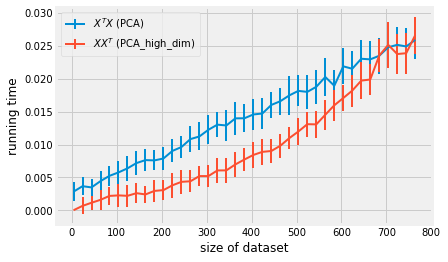

In [117]:
fig, ax = plt.subplots()
ax.set(xlabel='size of dataset', ylabel='running time')
bar = ax.errorbar(times_mm0[:, 0], times_mm0[:, 1], times_mm0[:, 2], label="$X^T X$ (PCA)", linewidth=2)
ax.errorbar(times_mm1[:, 0], times_mm1[:, 1], times_mm1[:, 2], label="$X X^T$ (PCA_high_dim)", linewidth=2)
ax.legend();

We first benchmark the time taken to compute $\boldsymbol X^T\boldsymbol X$ and $\boldsymbol X\boldsymbol X^T$. Jupyter's magic command `%time` is quite handy.

Next we benchmark `PCA`, `PCA_high_dim`.

In [118]:
times0 = []
times1 = []

for datasetsize in np.arange(4, 784, step=100):
    XX = Xbar[:datasetsize]
    npc = 2
    mu, sigma = time(lambda : XX.T @ XX)
    times0.append((datasetsize, mu, sigma))
    
    mu, sigma = time(lambda : XX @ XX.T)
    times1.append((datasetsize, mu, sigma))
    
times0 = np.asarray(times0)
times1 = np.asarray(times1)

Alternatively, use the `time` magic command.

In [119]:
%time Xbar.T @ Xbar
%time Xbar @ Xbar.T
pass # Put this here, so that our output does not show the result of computing `Xbar @ Xbar.T`

CPU times: user 60 ms, sys: 0 ns, total: 60 ms
Wall time: 32.8 ms
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 43.9 ms


We can also compare the running time for __PCA__ and __PCA\_high\_dim__ directly. Spend some time and think about what this plot means. We mentioned in lectures that `PCA_high_dim` are advantageous when
we have dataset size $N$ < data dimension $D$. Although our plot for the two running times does not intersect exactly at $N = D$, it does show the trend.

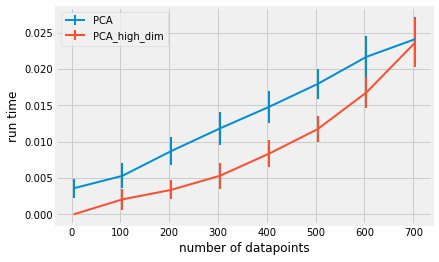

In [120]:
fig, ax = plt.subplots()
ax.set(xlabel='number of datapoints', ylabel='run time')
ax.errorbar(times0[:, 0], times0[:, 1], times0[:, 2], label="PCA", linewidth=2)
ax.errorbar(times1[:, 0], times1[:, 1], times1[:, 2], label="PCA_high_dim", linewidth=2)
ax.legend();

Again, with the magic command `time`.

In [121]:
%time PCA(Xbar, 2)
%time PCA_high_dim(Xbar, 2)
pass

LinAlgError: Array must not contain infs or NaNs